# 東北大による事前学習済み日本語用BERTモデルを用いたスラングを考慮した感情分析モデル

参考にしたColabNotebookは以下の通り↓  
[Hugging Faceを使って事前学習モデルを日本語の感情分析用にファインチューニングしてみた](https://colab.research.google.com/drive/1WZ2E6eWW1W853ynG4E0pxMCglZI7mER7)

### 開発環境
* Google Colaboratory
* ハードウェアアクセラレータ：T4GPU

### 注意事項
* 正しく動作するようになるまで実行は控えること
* AIXだとVersion違いで怒られる可能性が高いのでAnacondaの使い方を熟知してから仮想環境で実行するように
* データセットは用意でき次第自分のデータに変換するように

## 環境構築

必要なツールをpipでインストールする  
今回はBERTを用いて、外部からデータセットを持ってくるので以下の3つをインストールしてある  
バージョンが原因のエラーを回避するために```-U```オプションを付与しておく

*   ```transformers```
*   ```datasets```
*   ```accelerate```

In [ ]:
#@title transformersとdatasetsのインストール
# accelerateはオプション
!pip install -U transformers
!pip install -U datasets
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
# #@title バージョンの確認
# # transformers >= 4.34.1
# # accelerate >= 0.24.0
# # となっているかを確認(なっていないと学習でエラーを起こす)
# !pip list | grep transformers

transformers                     4.36.2


In [ ]:
# !pip list | grep accelerate

accelerate                       0.25.0


## データセットの取得

今回は日本語のサブセットを使用する。  
Ref: https://huggingface.co/datasets/tyqiangz/multilingual-sentiments

他のデータセットを使うのであれば[ここから](https://huggingface.co/datasets)

```dataset```を変更することでさまざまなデータを利用することができる  
GitHub上のデータから持ってくる方法は予備実験のColab Notebookを参考にして作成してください

### Amazon日本語レビューデータセットの場合

上記URLから既存のデータセットを持ってくる場合は以下の通りに実行する.

基本的には自身のデータセットを利用すること！  
データセットが大きいため、動作確認程度にとどめる.

In [ ]:
# #@title Amazon日本語レビューデータセットの取得
# from datasets import load_dataset
# amzdataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

In [ ]:
# #@title (オプション)DatasetDictの構造の確認
# # 不要ならば実行しなくて良い

# # 学習, 評価, テストデータセットのラベル(text, source, label)と数を確認
# amzdataset

例えばAmazonレビューのデータセットでは、以下のようになっている

```
DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})
```
つまり、  
* ```train```(学習用データ)は120000
* ```validation```(評価用データ)は3000
* ```test```(テストデータ)は3000

それぞれに対して数が十分存在するかを確認する。


In [ ]:
# #@title 各データをデータフレーム(pandas)として扱う
# amzdataset.set_format(type="pandas")
# train_df = amzdataset["train"][:]
# # データフレーム形式で最初の10個を表示させてみる
# train_df.head(10)

データ元はAmazonのレビューデータ, ```label```タブに感情ラベルが付与されていることがわかる。

In [ ]:
# #@title 学習用データフレームのsourceとlabelの内訳(数や型)をみてみる
# train_df.value_counts(["source", "label"])

In [ ]:
# #@title 各ラベルの意味を調べる
# amzdataset["train"].features

```source```は```amazon_reviews_multi```のみ, ```label```は0, 1, 2の3種類を取ることがわかる  


*   0: ```positive```
*   1: ```neutral```
*   2: ```negative```

※これはamazonレビューの場合のみ、他のデータセットではラベルが変わる  
それぞれのラベルに対してコメントが40000ずつ存在することがわかる

In [ ]:
# #@title ラベルを数値->ラベル名に変換
# def label_int2str(x):
# 	return amzdataset["train"].features["label"].int2str(x)

# train_df["label_name"] = train_df["label"].apply(label_int2str)
# train_df.head()

In [ ]:
# #@title データフレーム型のフォーマットを元に戻す
# amzdataset.reset_format()

### 外部(GitHub)等からcsvファイルを読み込む場合

自身のデータを利用する場合はこちらから.  
基本的にはGitHubにアップロードしてあるcsvファイルを利用する.  
適宜ファイルURLは変更して利用する.

[【初心者向け】ColaboratoryでCSVを読み込む最も簡単な方法 ⇒ Pandas (+Github)](https://qiita.com/zaq9/items/13562a5b78e4822801bc)

In [ ]:
#@title 外部(GitHub)からのrawデータ取得
import pandas as pd
import numpy as np
pd.set_option('display.unicode.east_asian_width', True)
from google.colab import files
import codecs
import warnings
warnings.simplefilter('ignore')

# github上に置いてあるrawデータを取り出して使用
file_url = 'https://raw.githubusercontent.com/sekiy13/b4SeniorProjectData/main/sentLabelData1107.csv'
df = pd.read_csv(file_url, encoding='utf-8')

df.head()

,label,humanLabel,text,score
0,NEUTRAL,1,この曲が半年たってもづっと見られます❤❤❤,0.7825
1,NEUTRAL,0,これ黒反転側のアイはアイを演じてるルビーって解釈もありですかね瞳の色がそれっぽい気が...,0.9330
2,NEUTRAL,1,まだ伸びてんのか,0.8069
3,NEGATIVE,-1,あぁついに人気3位になってしまったまだまだ伸びてほしいのに…...,0.9802
4,POSITIVE,0,J'アドレセッテチャンソン,0.5122


In [ ]:
#@title DataFrameの構造確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       2396 non-null   object 
 1   humanLabel  2396 non-null   int64  
 2   text        2396 non-null   object 
 3   score       2396 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 75.0+ KB


In [ ]:
#@title (オプション)ラベルの数値を置換 / ラベル名の変更 / 不要な要素を削除
df = df.replace({'humanLabel': {-1: 2}}) # negativeラベルの置換
df = df.replace({'humanLabel': {1: 100}})
df = df.replace({'humanLabel': {0: 1}}) # neutralラベルの置換
df = df.replace({'humanLabel': {100: 0}}) # positiveラベルの置換

# 不要な列を削除する(dfnew)
dfnew = df[["humanLabel", "text"]]

# 列名の置換(humanLabel -> label)
dfnew = dfnew.rename(columns={'humanLabel': 'label'})

dfnew.head()

,label,text
0,0,この曲が半年たってもづっと見られます❤❤❤
1,1,これ黒反転側のアイはアイを演じてるルビーって解釈もありですかね瞳の色がそれっぽい気が...
2,0,まだ伸びてんのか
3,2,あぁついに人気3位になってしまったまだまだ伸びてほしいのに…...
4,1,J'アドレセッテチャンソン


#### DataFrameからDatasetクラスを作成

読み込んだpandasのデータフレームから```train```、```validation```、```test```データセットを作成する.

[Hugging Faceで学習するためにcsvファイルからDatasetDictクラスを作成する方法](https://dev.classmethod.jp/articles/huggingface-usage-dataset/)

In [ ]:
#@title train, validation, testにデータフレームを分割
# trainを一番多くする
df_train = dfnew.loc[0:1438]
df_validation = dfnew.loc[1439:1918]
df_test = dfnew.loc[1919:2397]

In [ ]:
#@title Datasetクラスに変換してDatasetDictを作成
# Datasetクラスへ変換
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
validation_dataset = Dataset.from_pandas(df_validation)
test_dataset = Dataset.from_pandas(df_test)

# DatasetDictを作成
from datasets import DatasetDict
mydataset1 = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset,
})

In [ ]:
#@title 作成したDatasetDictの構造確認
mydataset1["train"].features

{'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
#@title ClassLabelクラスに変換
from datasets import ClassLabel

class_label = ClassLabel(num_classes=3, names=['positive', 'neutral', 'negative'])
mydataset = mydataset1.cast_column("label", class_label)

Casting the dataset:   0%|          | 0/1439 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/480 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/477 [00:00<?, ? examples/s]

In [ ]:
mydataset["train"].features

{'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
# #@title (オプション)作成したDatasetDictの確認
# # 不要ならば実行不要, 適宜必要箇所のみ実行(他コメントアウト)
# # DataFrame型(pandas)に戻して確認する
# mydataset.set_format(type="pandas")
# train_df = mydataset["train"][:]

# # データフレーム形式で最初の10個を表示させてみる：構造の確認
# # train_df.head(10)

# # ラベルを数値->ラベル名(pos/neu/neg)に変換：正しくラベル名が付与されているかの確認
# def label_int2str(x):
#   return mydataset["train"].features["label"].int2str(x)

# train_df["label_name"] = train_df["label"].apply(label_int2str)
# train_df.head()

# # (確認できたら)データフレーム型のフォーマットを元に戻す：エラー回避のため
# # mydataset.reset_format()

## トークナイザの準備

### ipadic-NEologdを用意する
初期状態の東北大BERTには通常のIPA辞書が利用されている

テーマ的には新語や造語に強いipadic-NEologdを利用した方が良い.

### 参考URL
[Google Colaboratoryにおいて、BertJapaneseTokenizerでmecab ipadic-NEologdを使う - Qiita](https://qiita.com/Ryo412/items/cdd447536397782ea394)  
[BertJapaneseTokenizerの辞書にNEologDを指定する - Zenn](https://zenn.dev/sinozu/articles/edd859f0e53b3f6c8b7d)

In [ ]:
#@title トークナイザのインストール
!pip install fugashi
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=b56a4076e7c740e32972a7bb25807730c5696ddb8784170a7cc244baee91b564
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
#@title Mecabのインストール
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30 swig4.0
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel libcwidget-dev xapian-tools
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30 swig swig4.0
0 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,954 kB of archives.
After this operation, 22.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:

In [ ]:
#@title gitを利用してmecab-ipadic-neologdをダウンロード
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Cloning into 'mecab-ipadic-neologd'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 5), reused 54 (delta 0), pack-reused 0
Receiving objects: 100% (75/75), 58.09 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (5/5), done.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[install-mecab-ipadic-NEologd] :     egrep => ok
[install-mecab-ipadic-NEologd] :     mecab => ok
[install-mecab-ipadic-NEologd] :     mecab-config => ok
[install-mecab-ipadic-NEologd] :     make => ok
[install-mecab-ipadic-NEologd] :     curl => ok
[install-mecab-ipadic-NEologd] :     sed => ok
[install-mecab-ipadic-NEologd] :     cat => ok
[install-mecab-ipadic-

In [ ]:
#@title (Google Colaboratoryのみ)パスを指定
# Google Colaboratoryでは、そのままだとデータが存在しないと怒られる
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

In [ ]:
#@title ipadic-NEologdへのパスを通す
# subprocessで他のプログラム(ここではパスを通すプログラム)を起動させる
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True).communicate()[0]).decode('utf-8')

ここの```path_neologd```を```tokenizer```で指定することでNEologd辞書を利用することができる。

### ipadic-NEologdが機能しているかを実行で確かめる

ipa辞書を用いた```tokenizer```とneologd辞書を利用した```tokenizer```の結果を比較して正しく機能していることを確かめる。

In [ ]:
#@title 必要ツールのインポート
import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
import MeCab

In [ ]:
#@title AutoTokenizerの呼び出し
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
# tokenizerの呼び出し: ここでipadic-NEologdへのパスを指定
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, mecab_kwargs={"mecab_dic": None, "mecab_option": "-d {0}".format(path_neologd)})

tokenizer_config.json:   0%|          | 0.00/110 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

In [ ]:
#@title トークナイザを試験運用
# sample_textにトークナイザを適用
sample_text = "\
機械学習のコア部分のロジックを、定型的な実装部分から切り離して\
定義できるようなインターフェースに工夫されています。 \
そのためユーザーは、機械学習のコア部分のロジックの検討に\
集中することができます。\
"

sample_text_encoded = tokenizer.tokenize(sample_text) # トークン文字列を出力
print(sample_text_encoded)

['機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'を', '、', '定型', '的', 'な', '実装', '部分', 'から', '切り離し', 'て', '定義', 'できる', 'よう', 'な', 'インターフェース', 'に', '工夫', 'さ', 'れ', 'て', 'い', 'ます', '。', 'その', '##た', '##め', 'ユーザー', 'は', '、', '機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'の', '検討', 'に', '集中', 'する', 'こと', 'が', 'でき', 'ます', '。']


In [ ]:
#@title トークン文字列を取得
sample_text_encoded1 = tokenizer(sample_text) # tokenizerのIDを出力
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded1.input_ids)
print(tokens)

['[CLS]', '機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'を', '、', '定型', '的', 'な', '実装', '部分', 'から', '切り離し', 'て', '定義', 'できる', 'よう', 'な', 'インターフェース', 'に', '工夫', 'さ', 'れ', 'て', 'い', 'ます', '。', 'その', '##た', '##め', 'ユーザー', 'は', '、', '機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'の', '検討', 'に', '集中', 'する', 'こと', 'が', 'でき', 'ます', '。', '[SEP]']


通常のipa辞書の結果は以下の通り。  
```
['[CLS]', '機械', '学習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'を', '、', '定型', '的', 'な', '実装', '部分', 'から', '切り離し', 'て', '定義', 'できる', 'よう', 'な', 'インターフェース', 'に', '工夫', 'さ', 'れ', 'て', 'い', 'ます', '。', 'その', 'ため', 'ユーザー', 'は', '、', '機械', '学習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'の', '検討', 'に', '集中', 'する', 'こと', 'が', 'でき', 'ます', '。', '[SEP]']
```

ipadic-NEologdを用いて以下のようになっていれば、正しく辞書を利用できていることがわかる。

```
['[CLS]', '機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'を', '、', '定型', '的', 'な', '実装', '部分', 'から', '切り離し', 'て', '定義', 'できる', 'よう', 'な', 'インターフェース', 'に', '工夫', 'さ', 'れ', 'て', 'い', 'ます', '。', 'その', '##た', '##め', 'ユーザー', 'は', '、', '機械', '##学', '##習', 'の', 'コア', '部分', 'の', 'ロ', '##ジック', 'の', '検討', 'に', '集中', 'する', 'こと', 'が', 'でき', 'ます', '。', '[SEP]']
```



## tokenizerの追加学習

[東北大BERT](https://www.nlp.ecei.tohoku.ac.jp/news-release/3284/)は```tokenizer```に以下の2種類を利用している。

*  Mecab
*  WordPiece

これらを学習するには以下のサイトを参考にする。  
[日本語でHugging Face Tokenizersを利用する - MNTSQ](https://tech.mntsq.co.jp/entry/2021/02/26/120013)

```SentencePiece```を利用する場合は以下のコードで実行できるらしい。  
[huggingface / transformersを使って日本語BERTの事前学習を実施してオリジナルな言語モデルを作ってみる - Qiita](https://qiita.com/m__k/items/6f71ab3eca64d98ec4fc)

```
# sentencepieceはpipでインストールできます。
# !pip install sentencepiece

from sentencepiece import SentencePieceTrainer

SentencePieceTrainer.Train(
    '--input='+drive_dir+'corpus/corpus.txt, --model_prefix='+drive_dir+'souseki_sentencepiece --character_coverage=0.9995 --vocab_size=32000 --pad_id=3 --add_dummy_prefix=False'
)
```



### tokenizerに専門用語を追加

1.   GitHub上に上げたトークンをまとめたcsvファイルの読み込み
2.   ```token```列のみ呼び出してリスト化
3.   ```add_tokens```を利用して単語を追加

[日本語BERTに新しい単語（ユーザ辞書）を追加してみる - Qiita](https://qiita.com/m__k/items/e620bc14fba7a4e36824)  
[pandasにcsvを読み込み指定列をリストにする - Qiita](https://qiita.com/madaaamj/items/f07619d68bd836eda4af)

In [ ]:
#@title GitHub上のユーザ辞書ファイルを読み込む

# 外部データを利用する際はコメントアウト
import pandas as pd
import numpy as np
pd.set_option('display.unicode.east_asian_width', True)
from google.colab import files
import codecs
import warnings
warnings.simplefilter('ignore')

# github上に置いてあるrawデータを取り出して使用
file_url = 'https://raw.githubusercontent.com/sekiy13/b4SeniorProjectData/main/user_dic.csv'
df_dic = pd.read_csv(file_url, encoding='utf-8')

# サンプルで表示
df_dic.head()

,token,yomigana,mean
0,あう,あう,au
1,尼,あま,amazon
2,痛車,いたしゃ,
3,今北産業,いまきたさんぎょう,NaN
4,イヤンホホ,いやんほほ,イヤホン


In [ ]:
#@title ユーザ辞書のリスト化
# user_dic.csvのうち1列目(追加したい単語)の情報のみ

list_dic = list(df_dic['token'])
print(list_dic)

['あう', '尼', '痛車', '今北産業', 'イヤンホホ', 'インスコ', 'うp', 'うp乙', 'うぽつ', '大友', '乙', 'おまw', 'オワコン', '希ガス', 'キモオタ', 'ググる', 'ググれ', '香ばしい', '情弱', 'ステマ', 'ちょw', 'ネトウヨ', 'ネトサヨ', 'ポチる', 'マ？', 'マジレス', '胸熱', 'リア充', '(ry', 'ggrks', 'GJ', 'JS', 'JC', 'JK', 'JD', 'ktkr', 'lol', 'OMG', 'ROM', 'thx', 'w', 'wtf', 'アンチ', '炎上', 'キタコレ', '黒歴史', 'コピペ', '三次元', '自宅警備員', '人権', '信者', '弾幕', '二次元', '廃人', 'メンヘラ', '有能', 'ワクテカ', '垢', 'ネ申', '鯖', '鯖落ち', '儲', '厨二病', 'ようつべ', 'ワロタ', '中毒性', 'CM', 'リピ', 'ヤヴァイ', 'カプヌ', 'スコ', 'すこ', 'ドチャ', 'クオ', 'w', 'きゅうくらりん', '良', 'まっさか', 'オッス', 'かわちぃ', 'かわちい', 'ググる', 'ググっ', 'ググら', 'ググり', 'ググれ', 'ググろ', 'ググん', 'グンマー']


In [ ]:
#@title ユーザ辞書の追加
tokenizer.add_tokens(list_dic, special_tokens=True)

# 出力結果の確認
# sample_textにトークナイザを適用
sample_text1 = "１度聴いたら脳内リピされる🤣中毒性高過ぎ😆"
sample_text_encoded1 = tokenizer(sample_text1)
tokens_1 = tokenizer.convert_ids_to_tokens(sample_text_encoded1.input_ids)
print(tokens_1)

['[CLS]', '1', '##度', '聴い', 'たら', '脳', '内', 'リピ', 'さ', 'れる', '[UNK]', '中毒性', '高', '過ぎ', '[UNK]', '[SEP]']


トークン追加前の出力結果は以下の通り。
```
['[CLS]', '1', '度', '聴い', 'たら', '脳', '内', 'リ', '##ピ', 'さ', 'れる', '[UNK]', '中毒', '性', '高', '過ぎ', '[UNK]', '[SEP]']
```
```add_tokens```を追加することで以下のように出力されていれば正しくトークンが追加されたと考えて良い。(中毒性の部分)
```
['[CLS]', '1', '##度', '聴い', 'たら', '脳', '内', 'リピ', 'さ', 'れる', '[UNK]', '中毒性', '高', '過ぎ', '[UNK]', '[SEP]']
```


In [ ]:
tokenizer.model_max_length

512

### tokenizerの追加学習

In [ ]:
#@title Googleドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title ドライブの場所を変数に格納
drive_dir = '/content/drive/MyDrive/'

In [ ]:
from transformers import AutoTokenizer

# 東北大BERTを選択
model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
# 既存のtokenizerの呼び出し
# default_tokenizer = AutoTokenizer.from_pretrained(model_ckpt, mecab_kwargs={"mecab_dic": None, "mecab_option": "-d {0}".format(path_neologd)})
# default_tokenizer = AutoTokenizer.from_pretrained(model_ckpt, is_fast=True)
default_tokenizer = AutoTokenizer.from_pretrained("gpt2")
# ユーザ辞書の追加
# default_tokenizer.add_tokens(list_dic, special_tokens=True)
# print(default_tokenizer.vocab_size)
default_tokenizer

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
from transformers import BertJapaneseTokenizer

class BertJapaneseTokenizerFast(BertJapaneseTokenizer):
  def __call__(self,text,text_pair=None,return_offsets_mapping=False,**kwargs):
    v=super().__call__(text=text,text_pair=text_pair,return_offsets_mapping=False,**kwargs)
    if return_offsets_mapping:
      import tokenizations
      if type(text)==str:
        z=zip([v["input_ids"]],[text],[text_pair] if text_pair else [""])
      else:
        z=zip(v["input_ids"],text,text_pair if text_pair else [""]*len(text))
      w=[]
      for a,b,c in z:
        a2b,b2a=tokenizations.get_alignments(self.convert_ids_to_tokens(a),b+c)
        x=[]
        for i,t in enumerate(a2b):
          if t==[]:
            s=(0,0)
            if a[i]==self.unk_token_id:
              j=[[-1]]+[t for t in a2b[0:i] if t>[]]
              k=[t for t in a2b[i+1:] if t>[]]+[[len(b+c)]]
              s=(j[-1][-1]+1,k[0][0])
          elif t[-1]<len(b):
            s=(t[0],t[-1]+1)
          else:
            s=(t[0]-len(b),t[-1]-len(b)+1)
          x.append(s)
        w.append(list(x))
      v["offset_mapping"]=w[0] if type(text)==str else w
    return v

In [ ]:
#@title 必要なツールのインポート
from transformers import AutoTokenizer
from typing import List

In [ ]:
default_tokenizer = BertJapaneseTokenizerFast.from_pretrained(model_ckpt)

In [ ]:
#@title tokenizerの追加学習
def get_training_corpus(texts: List[str]):
    for start_idx in range(0, len(texts), 100):
        samples = texts[start_idx : start_idx + 100]
        yield samples

with open(drive_dir + 'corpus/snippetList.txt') as f:
    texts = f.readlines()

training_corpus = get_training_corpus(texts)
new_tokenizer = default_tokenizer.train_new_from_iterator(
    training_corpus, vocab_size=default_tokenizer.vocab_size
)
new_tokenizer.save_pretrained("./outputs/")

## モデルの追加学習

*  ```tokenizer```の追加学習
*  ```model```の追加学習

[huggingface / transformersを使って日本語BERTの事前学習を実施してオリジナルな言語モデルを作ってみる](https://qiita.com/m__k/items/6f71ab3eca64d98ec4fc)

### BERTモデルのconfigを設定

ここちょっとわかってない。
[cl-tohoku/bert-japanese - GitHub](https://github.com/cl-tohoku/bert-japanese)

的には、東北大BERTはMLMに特化するために作られているらしいので、追加事前学習もMLMに特化する形で学習するといいのかなと思う

In [ ]:
#@title BERTモデルのconfigを設定する
import torch
from transformers import BertForMaskedLM

# GPU利用の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLM特化型のモデルを設定
model = (BertForMaskedLM.from_pretrained(model_ckpt).to(device))

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#@title 追加学習用のデータセットの準備
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
     tokenizer = tokenizer,
     file_path = drive_dir + 'corpus/snippetList.txt',
     block_size = tokenizer.model_max_length, # tokenizerのmax_length
)

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer = tokenizer,
    mlm = True,
    mlm_probability = 0.15
)

### 【超重要】モデルの```embedding```層にベクトルを追加する

```add_tokens```で単語を追加しただけでは、```model```の部分でベクトルが無くエラーとなる(下記参照)。それを回避するためにランダムなベクトルを追加した単語に追加して```embedding```の行数を拡大することができる。
```
model(ids)

# 〜省略〜
#/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py in embedding(input, weight, padding_idx, max_norm, norm_type, scale_grad_by_freq, sparse)
#   1914         # remove once script supports set_grad_enabled
#   1915         _no_grad_embedding_renorm_(weight, input, max_norm, norm_type)
#-> 1916     return torch.embedding(weight, input, padding_idx, scale_grad_by_freq, sparse)
#   1917
#   1918
#IndexError: index out of range in self
```

In [ ]:
#@title 追加した単語のベクトルを追加する
model.resize_token_embeddings(len(tokenizer))

Embedding(32067, 768)

### modelの追加事前学習

```TrainigArguments```で事前学習に関するパラメータを設定し、```Trainer```で事前学習するインスタンスを作成。

【現状の設定】  
*   epoch数：10
*   ```per_device_train_batch_size```：32
*   GPU消費：約10GB

In [ ]:
#@title 学習の設定
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir= drive_dir + 'slangBERT1228/',
    overwrite_output_dir=True,
    num_train_epochs=50, # 元のコード:10
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    save_steps=10000,
    save_total_limit=2,
    prediction_loss_only=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset
)

In [ ]:
#@title 学習の実行
trainer.train()
trainer.save_model(drive_dir + 'slangBERT1228/')

Step,Training Loss
500,1.036500
1000,1.101400
1500,2.052600
2000,2.042300
2500,1.949300
3000,1.859600
3500,1.787900
4000,1.757500
4500,1.700900
5000,1.655700


In [ ]:
lossdf = pd.DataFrame(trainer.state.log_history)
lossdf.head()

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.0365,0.000019,2.92,500,NaN,NaN,NaN,NaN,NaN
1,1.1014,0.000018,5.85,1000,NaN,NaN,NaN,NaN,NaN
2,2.0526,0.000016,8.77,1500,NaN,NaN,NaN,NaN,NaN
3,2.0423,0.000015,11.70,2000,NaN,NaN,NaN,NaN,NaN
4,1.9493,0.000014,14.62,2500,NaN,NaN,NaN,NaN,NaN


In [ ]:
def my_func(x):
    return x - 1000

<Axes: xlabel='step'>

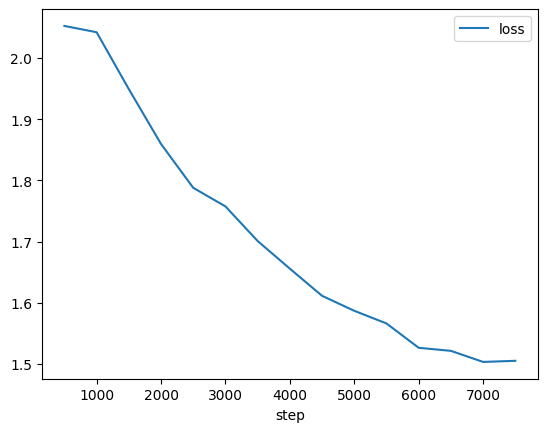

In [ ]:
lossdfnew = lossdf[2:]
lossdfnew["step"] = lossdfnew["step"].apply(lambda x: x - 1000)
lossdfnew.plot(x="step", y="loss")

## テキスト分類器の実現方法

追加事前学習をしたモデル```slangBERT```を利用したテキスト分類器の設定

やること↓
tokenizerの変更(ミスって初期東北大BERTのもののままなので)

追加の事前学習はそれでいいけど、改めて呼び出さないとダメだわこれ


### データセット全体に対してtokenizerを適用

#### Amazonレビューデータセットを利用する場合
*   tokenize前：```mydataset```
*   tokenize後：```dataset_encoded```

#### GitHub上のデータセットを利用する場合
*   tokenize前：```dataset```
*   tokenize後：```dataset_encoded```

In [ ]:
#@title tokenizerとmodelの再読み込み
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

# new_tokenizer = AutoTokenizer.from_pretrained(drive_dir + 'slangBERT/')
model = (AutoModelForSequenceClassification.from_pretrained(drive_dir + 'slangBERT/', num_labels=num_labels).to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/slangBERT/ and are newly initialized: ['classifier.weight', 'classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#@title トークン化関数(csv専用)
# 取得したcsvのデータセットにトークン化を施す関数

# padding=Trueでバッチ内の最も長い系列長に合うようpaddingする処理を有効にする
# truncation=Trueで、後段のモデルが対応する最大コンテキストサイズ以上を切り捨てる
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
# GitHub上のデータセットを利用する場合
dataset_encoded = mydataset.map(tokenize, batched=True, batch_size=None)
# Amazonレビューデータセットを利用する場合
# dataset_encoded = amzdataset.map(tokenize, batched=True, batch_size=None)

Parameter 'function'=<function tokenize at 0x7baf8363ca60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

Map:   0%|          | 0/477 [00:00<?, ? examples/s]

In [ ]:
#@title トークン化したデータセットの確認
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1439
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 480
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 477
    })
})

In [ ]:
#@title サンプル単位で結果を確認する
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame([sample_encoded["input_ids"], sample_encoded["attention_mask"], tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])], ['input_ids', 'attention_mask', "tokens"]).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,70,1,この
2,543,1,曲
3,14,1,が
4,7315,1,半年
...,...,...,...
358,0,0,[PAD]
359,0,0,[PAD]
360,0,0,[PAD]
361,0,0,[PAD]


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

In [ ]:
new_tokenizer = (AutoTokenizer.from_pretrained(drive_dir + 'slangBERT/', mecab_kwargs={"mecab_dic": None, "mecab_option": "-d {0}".format(path_neologd)}).to(device))
model = (AutoModelForSequenceClassification.from_pretrained(drive_dir + 'slangBERT/', num_labels=num_labels).to(device))

### 必要なパラメータ等を準備する

評価指標は以下の3つとする

*   ```Training Loss```：学習用データを利用した損失
*   ```Validation Loss```：評価用データを利用した損失
*   ```Accuracy```：精度
*   ```F1 Score```：F1スコア

In [ ]:
#@title トレーニングの準備
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
#@title 学習用パラメータの設定
# TrainingArgumentsクラスを用いて設定
from transformers import TrainingArguments

batch_size =  20
logging_steps = len(dataset_encoded["train"]) // batch_size
# logging_steps = 10000
model_name = "sample-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [ ]:
#@title 学習の実行(時間がかかるので注意)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.134000,0.945952,0.770833,0.763812
2,0.101200,0.970338,0.802083,0.796318
3,0.048900,1.114237,0.785417,0.780267
4,0.017800,1.331576,0.770833,0.755642
5,0.019800,1.305987,0.789583,0.788290
6,0.010800,1.409686,0.787500,0.779056
7,0.001600,1.465092,0.793750,0.783924
8,0.007300,1.484465,0.795833,0.785279
9,0.009300,1.463965,0.791667,0.783349
10,0.001300,1.468494,0.791667,0.783401


TrainOutput(global_step=720, training_loss=0.03472636131935158, metrics={'train_runtime': 921.1018, 'train_samples_per_second': 15.623, 'train_steps_per_second': 0.782, 'total_flos': 2684358116096580.0, 'train_loss': 0.03472636131935158, 'epoch': 10.0})

## 結果の確認

結果をグラフにして```training_loss```や```validation_loss```の変化を確認する.

過学習や学習不足になっていないかをグラフで確認して適切な学習量になるようにする.



In [ ]:
preds_output = trainer.predict(dataset_encoded["validation"])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["validation"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
# import shutil

In [ ]:
# ! pwd

In [ ]:
# shutil.rmtree('/content/sample-text-classification-bert')